In [22]:
# 📦 Data wrangling
import pandas as pd
import numpy as np
import re
import string

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 📝 NLP - NLTK
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

# ⚡ NLP - spaCy
import spacy
import contractions 

# 🤖 Machine Learning tools
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, DataCollatorWithPadding 


In [3]:

# NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df = pd.read_csv('Arknights.csv')

In [4]:
# 1. Cleaning
def cleaningText(text):
    # hapus link
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    # hapus HTML entities
    text = re.sub(r"&\w+;", ' ', text)
    # hapus karakter non-ASCII kecuali emoji
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # hapus tanda baca kecuali apostrof (biar kontraksi bisa di-expand)
    text = re.sub(r"[^\w\s']", '', text)
    # ubah newline ke spasi
    text = text.replace("\n", " ")
    # hapus spasi berlebihan
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 2. Casefolding
def casefoldingText(text):
    return text.casefold()  # lebih aman dari lower()

# Fungsi expand contraction
def expand_contractions(text):
    return contractions.fix(text)

# 3. Tokenizing
def tokenizingText(text):
    # Tokenisasi
    tokens = word_tokenize(text)
    # Hapus apostrof tunggal yang tersisa (misal 's atau 're)
    tokens = [token.replace("'", "") for token in tokens]
    return tokens

# 4. Stopwords Filtering
stop_words = set(stopwords.words('english'))
custom_stopwords = {
    "time", "one", "get", "make", "go", "play", "really", "still", "even", "well",
    "much", "many", "lot", "thing", "stuff", "something", "anything", "everything", "nothing",
    "also", "maybe", "actually", "probably", "almost", "kinda", "sort", "bit", "very",
    "etc", "like", "just", "pretty", "rather", "quite", "somehow",
    "game", "app", "application", "gameplay", "character", "horse", "girl", "story",
    "graphics", "system", "feature", "update", "dev", "developer", "version",
    "can", "could", "would", "should", "may", "might", "will", "shall", "must",
    "i", "me", "my", "we", "us", "our", "you", "your", "they", "them", "their", "he", "she", "it", "its"
}
stop_words.update(custom_stopwords)
def filteringText(tokens):
    return [word for word in tokens if word not in stop_words]

# 5. Slang Normalization
# Fungsi untuk baca slang dari file txt
def load_slang_dict(filepath="slang.txt"):
    slang_dict = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if "=" in line:  # pastikan format benar
                key, value = line.split("=", 1)
                slang_dict[key.strip().lower()] = value.strip()
    return slang_dict

# Fungsi normalisasi teks
def normalize_text(text, slang_dict):
    # urutkan slang dari yang panjang ke pendek supaya frasa lebih dulu diproses
    for slang in sorted(slang_dict.keys(), key=len, reverse=True):
        pattern = r"\b" + re.escape(slang) + r"\b"
        text = re.sub(pattern, slang_dict[slang], text, flags=re.IGNORECASE)
    return text

slang_dict = load_slang_dict("slang.txt")

# 6. Lemmatization (spaCy)
nlp = spacy.load("en_core_web_sm")

def lemmatizationText(tokens):
    doc = nlp(" ".join(tokens))  # spaCy butuh kalimat
    return [token.lemma_ for token in doc]

# 7. To sentence
def toSentence(list_words):
    return " ".join(word for word in list_words)

In [5]:
def preprocess_review(text, slang_dict):
    text = cleaningText(text)            # 1. Cleaning
    text = casefoldingText(text)         # 2. Casefolding
    text = expand_contractions(text)     # 3. Expand contractions (🔥 di sini)
    text = normalize_text(text, slang_dict)  # 4. Slang normalization
    tokens = tokenizingText(text)        # 5. Tokenizing
    tokens = filteringText(tokens)       # 6. Stopword filtering
    tokens = lemmatizationText(tokens)   # 7. Lemmatization
    return toSentence(tokens)            # 8. To sentence

from tqdm import tqdm
tqdm.pandas()  # aktifkan tqdm untuk pandas

df['text_final'] = df['content'].fillna("").progress_apply(lambda x: preprocess_review(x, slang_dict))

100%|██████████| 10000/10000 [00:48<00:00, 205.42it/s]


In [6]:
import pandas as pd
from collections import Counter

def get_most_common_words(texts, top_n=100):
    all_tokens = []
    for text in texts:
        cleaned = cleaningText(text)          # pakai fungsi cleaning kamu
        lowered = casefoldingText(cleaned)
        tokens = tokenizingText(lowered)
        all_tokens.extend(tokens)

    # hitung frekuensi kata
    counter = Counter(all_tokens)
    return counter.most_common(top_n)


# Ambil kolom review
reviews = df["text_final"].dropna().tolist()

# Cari kata paling sering muncul
common_words = get_most_common_words(reviews, top_n=100)

# Masukkan ke DataFrame supaya rapi
df_freq = pd.DataFrame(common_words, columns=["word", "count"])

# Lihat hasil
df_freq

,word,count
0,good,2970
1,gacha,2385
2,play,1521
3,great,1270
4,love,1209
...,...,...
95,anime,224
96,attempt,223
97,phone,221
98,lose,215


In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Inisialisasi VADER
sia = SentimentIntensityAnalyzer()

# Update lexicon supaya kata slang yang sudah dinormalisasi punya bobot sentimen
custom_words = {
    "generous": 2.5,   # positif
    "stingy": -2.5,    # negatif
}

sia.lexicon.update(custom_words)

# Contoh fungsi untuk kasih label
def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']  # ambil skor compound
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Contoh: buat kolom label dari review
df['label'] = df['text_final'].apply(get_sentiment)
print(df['label'].value_counts())

label
positive    7016
neutral     1750
negative    1234
Name: count, dtype: int64


In [8]:
X = df["text_final"]
y = df["label"]


In [9]:
print("\n=== Percobaan 1: SVM + TF-IDF + 80/20 ===")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Akurasi training
y_train_pred = svm_model.predict(X_train_tfidf)
train_acc_svm = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_acc_svm)

# Akurasi testing
y_test_pred = svm_model.predict(X_test_tfidf)
test_acc_svm = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_acc_svm)

print(classification_report(y_test, y_test_pred))


=== Percobaan 1: SVM + TF-IDF + 80/20 ===
Train Accuracy: 0.96375
Test Accuracy: 0.904
              precision    recall  f1-score   support

    negative       0.81      0.62      0.70       237
     neutral       0.81      0.90      0.85       343
    positive       0.94      0.95      0.95      1420

    accuracy                           0.90      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.90      0.90      0.90      2000



In [10]:
print("\n=== Percobaan 2: LightGBM + TF-IDF + 75/25 ===")
# Encode y (label)
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # ['negative','neutral','positive'] -> [0,1,2]

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# === TF-IDF ===
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # bisa diatur
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# === SMOTE ===
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

print("Sebelum SMOTE:", np.bincount(y_train))
print("Sesudah SMOTE:", np.bincount(y_train_res))

# === LightGBM + Hyperparameter Tuning ===
param_dist = {
    "n_estimators": [200, 500, 800],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [10, 20, -1],  
    "num_leaves": [31, 63, 127],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0]
}

lgbm = LGBMClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Training
random_search.fit(X_train_res, y_train_res)

# Evaluasi
best_lgbm = random_search.best_estimator_
y_train_pred = best_lgbm.predict(X_train_res)
train_acc_lgbm = accuracy_score(y_train_res, y_train_pred)
print("Train Accuracy:", train_acc_lgbm)

# Prediksi pada testing set (gunakan X_test_tfidf, bukan X_test)
y_test_pred = best_lgbm.predict(X_test_tfidf)
test_acc_lgbm = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_acc_lgbm)

print(classification_report(y_test, y_test_pred, target_names=le.classes_))


=== Percobaan 2: LightGBM + TF-IDF + 75/25 ===
Sebelum SMOTE: [ 925 1313 5262]
Sesudah SMOTE: [5262 5262 5262]
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48262
[LightGBM] [Info] Number of data points in the train set: 15786, number of used features: 1551
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\andre\Documents\data\Proyek-NNL\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train Accuracy: 0.9924616749018117
Test Accuracy: 0.914
              precision    recall  f1-score   support

    negative       0.78      0.71      0.74       309
     neutral       0.87      0.91      0.89       437
    positive       0.95      0.95      0.95      1754

    accuracy                           0.91      2500
   macro avg       0.87      0.86      0.86      2500
weighted avg       0.91      0.91      0.91      2500



c:\Users\andre\Documents\data\Proyek-NNL\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [24]:
print("\n=== Percobaan 3 : BERT Fine Tunned + 80/20 ===")
# 1. Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # ['negative','neutral','positive'] -> [0,1,2]

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 3. HuggingFace Dataset
df_train = pd.DataFrame({'text': X_train, 'label': y_train})
df_test = pd.DataFrame({'text': X_test, 'label': y_test})

train_ds = Dataset.from_pandas(df_train)
test_ds = Dataset.from_pandas(df_test)

# 4. Tokenizer + preprocessing
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def preprocess(batch):
    return tokenizer(batch['text'], truncation=True, padding=True)  # dynamic padding

train_ds = train_ds.map(preprocess, batched=True)
test_ds = test_ds.map(preprocess, batched=True)

# 5. Model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=3
)

# 6. Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 7. Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

# 8. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 9. Train model
trainer.train()

# 10. Evaluate
# Training set
train_pred = trainer.predict(train_ds)
y_train_true = train_pred.label_ids
y_train_pred = train_pred.predictions.argmax(-1)
print("Train Accuracy:", accuracy_score(y_train_true, y_train_pred))

# Testing set
test_pred = trainer.predict(test_ds)
y_test_true = test_pred.label_ids
y_test_pred = test_pred.predictions.argmax(-1)
print("Test Accuracy:", accuracy_score(y_test_true, y_test_pred))

# Classification report
print(classification_report(y_test_true, y_test_pred, target_names=le.classes_))


=== Percobaan 3 : BERT Fine Tunned + 80/20 ===


Map: 100%|██████████| 2000/2000 [00:00<00:00, 6098.88 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\andre\AppData\Local\Temp\ipykernel_6112\1860837187.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\andre\Documents\data\Proyek-NNL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.227800,0.239019,0.927500,0.926091
2,0.136800,0.223023,0.942500,0.942353
3,0.069100,0.243055,0.947000,0.946562


c:\Users\andre\Documents\data\Proyek-NNL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\Documents\data\Proyek-NNL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\andre\Documents\data\Proyek-NNL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Accuracy: 0.987875


c:\Users\andre\Documents\data\Proyek-NNL\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 0.947
              precision    recall  f1-score   support

    negative       0.85      0.83      0.84       247
     neutral       0.95      0.89      0.92       350
    positive       0.96      0.98      0.97      1403

    accuracy                           0.95      2000
   macro avg       0.92      0.90      0.91      2000
weighted avg       0.95      0.95      0.95      2000



In [29]:
train_acc_bert = accuracy_score(y_train_true, y_train_pred)
test_acc_bert = accuracy_score(y_test_true, y_test_pred)

In [28]:
# Simpan hasil tiap model
results_summary = []

# SVM
results_summary.append({
    "Model": "SVM + TF-IDF + 80/20",
    "Train Accuracy": train_acc_svm,
    "Test Accuracy": test_acc_svm
})

# LightGBM
results_summary.append({
    "Model": "LightGBM + TF-IDF + 75/25",
    "Train Accuracy": train_acc_lgbm,
    "Test Accuracy": test_acc_lgbm
})

# BERT Fine-tuned
results_summary.append({
    "Model": "BERT Fine-tuned + 80/20",
    "Train Accuracy": train_acc_bert,
    "Test Accuracy": test_acc_bert
})

# Tampilkan sebagai tabel
df_summary = pd.DataFrame(results_summary)
print(df_summary)

                       Model  Train Accuracy  Test Accuracy
0       SVM + TF-IDF + 80/20        0.963750          0.904
1  LightGBM + TF-IDF + 75/25        0.992462          0.914
2    BERT Fine-tuned + 80/20        0.987875          0.947


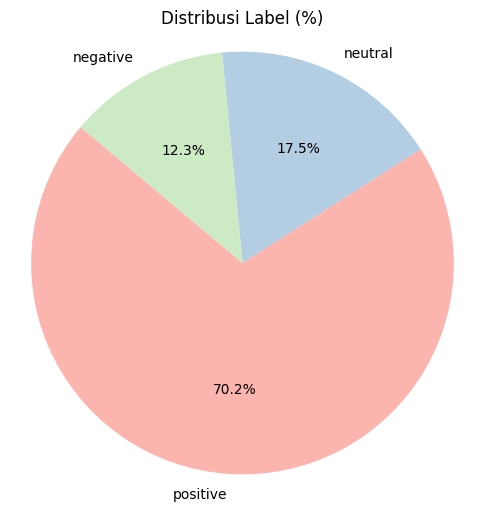

In [30]:
# Hitung distribusi label
label_counts = df['label'].value_counts()
label_percent = label_counts / label_counts.sum() * 100

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(label_percent, labels=label_percent.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Distribusi Label (%)')
plt.axis('equal')
plt.show()